# Plant Stress Classification using NIR Spectroscopy and a 1D CNN

### Introduction
This notebook outlines the process of building a deep learning model to classify different types of stress in plants using Near-Infrared (NIR) spectroscopy data. The goal is to determine if spectral data alone can be used to accurately identify the specific stressor affecting a plant.

### Dataset
The data is sourced from the `Datos1_InteraccionesNIR.xlsx` file, which contains spectral measurements for plants under various stress conditions.
- **Features**: The dataset consists of spectral reflectance values across a range of wavelengths (350nm to 2500nm).
- **Target**: The `Tratamiento` column indicates the specific stress condition applied to each plant, serving as our classification label.

### Libraries and Tools
We will use the following Python libraries:
- **`pandas` & `numpy`**: For data loading, manipulation, and numerical operations.
- **`scikit-learn`**: For preprocessing tasks like label encoding and splitting the data into training, validation, and test sets.
- **`keras` (from `tensorflow`)**: To build, train, and evaluate a 1D Convolutional Neural Network (CNN).
- **`matplotlib` & `seaborn`**: For visualizing the model's training history and performance.

### Objective
The main objective is to construct a 1D CNN model capable of classifying plant stress types from their NIR spectral profiles. We will train the model and then evaluate its accuracy on unseen data to gauge its effectiveness.

In [12]:
# Lets import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import keras

# import the data from the excel file with multiple sheets
df1_0 = pd.read_excel("Datos1_InteraccionesNIR.xlsx", sheet_name=0)
df1_1 = pd.read_excel("Datos1_InteraccionesNIR.xlsx", sheet_name=1)
df1_2 = pd.read_excel("Datos1_InteraccionesNIR.xlsx", sheet_name=2)
df1_3 = pd.read_excel("Datos1_InteraccionesNIR.xlsx", sheet_name=3)


# Concatenate all sheets into a single DataFrame
df1 = pd.concat([df1_0, df1_1, df1_2, df1_3], ignore_index=True)
df1.shape


(955, 2153)

In [13]:
#Let's separate the features and the target variable
X_features = df1.drop(columns=["Tratamiento", "Planta"])

y_target = df1["Tratamiento"]

print("features dataframe:")
X_features.head()

features dataframe:


,350,351,352,353,354,355,356,357,358,359,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.061030,0.060394,0.053344,0.054736,0.057163,0.055928,0.049880,0.043096,0.041127,0.044614,...,0.044963,0.044834,0.044802,0.044657,0.044370,0.044198,0.044046,0.043928,0.043878,0.043752
1,0.060823,0.060909,0.056016,0.056755,0.057975,0.056499,0.051715,0.047413,0.045700,0.046623,...,0.037656,0.037458,0.037266,0.037120,0.036929,0.036832,0.036861,0.036779,0.036661,0.036570
2,0.059742,0.060113,0.057320,0.059280,0.059741,0.057078,0.053557,0.049205,0.047486,0.048903,...,0.036252,0.036049,0.035732,0.035558,0.035431,0.035338,0.035368,0.035286,0.035157,0.035058
3,0.048861,0.047099,0.044486,0.049340,0.052701,0.050598,0.044007,0.038449,0.036496,0.038123,...,0.033894,0.033762,0.033693,0.033536,0.033412,0.033204,0.032831,0.032637,0.032501,0.032376
4,0.063155,0.060788,0.057388,0.058424,0.060128,0.059009,0.053017,0.048921,0.047316,0.048053,...,0.033897,0.033729,0.033675,0.033571,0.033515,0.033441,0.033317,0.033257,0.033285,0.033205


In [14]:
print("target variable:")
print(y_target.head())

num_classes = y_target.nunique()
print(f"Number of unique classes in target variable: {num_classes}")


target variable:
0    Control
1    Control
2    Control
3    Control
4    Control
Name: Tratamiento, dtype: object
Number of unique classes in target variable: 8


In [15]:
# lets split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [16]:
# Get the validatiion set from the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [17]:
# Encode the target variable

# Ordinal encoding of the target variable
encoder = OrdinalEncoder()
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.values.reshape(-1, 1))
print("Encoded target variable:")
print(y_train_encoded[:5])

# Since model uses sparse_categorical_crossentropy loss, we keep the integer labels
# Just flatten the arrays for proper shape
y_train = y_train_encoded.flatten()
y_test = y_test_encoded.flatten()
y_val = y_val_encoded.flatten()

Encoded target variable:
[[0.]
 [5.]
 [4.]
 [0.]
 [3.]]


Let's make a 1 dimensional Convolutional Neural Network (1D CNN) using TensorFlow/Keras.

In [18]:
# Reshape the input data for Conv1D (samples, timestamps, features)
# We need to add an extra dimension to the data
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)

# Define the input shape for our Conv1D model
input_shape = (X_train.shape[1], 1)  # (2151, 1)
print(f"Input shape: {input_shape}")


# Build the 1D CNN model
model = keras.Sequential([
    # Input layer
    keras.layers.Input(shape=input_shape),

    # First Conv1D block
    keras.layers.Conv1D(filters=32, kernel_size=15, activation='relu', padding='same'),
    keras.layers.MaxPooling1D(pool_size=4),
    
    # Second Conv1D block
    keras.layers.Conv1D(filters=64, kernel_size=9, activation='relu', padding='same'),  
    keras.layers.MaxPooling1D(pool_size=4),

    # Third Conv1D block
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),  
    keras.layers.MaxPooling1D(pool_size=4),


    # Flatten the output to feed into Dense layers
    keras.layers.Flatten(),
    
    # Dense hidden layer
    keras.layers.Dense(128, activation='relu'),
    
    # Dropout for regularization to prevent overfitting
    keras.layers.Dropout(0.5),
    
    # Output layer with softmax for multi-class classification
    keras.layers.Dense(num_classes, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

Input shape: (2151, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 2151, 32)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 537, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 537, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 134, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 134, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 33, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4224)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       540,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601,928 (2.30 MB)

 Trainable params: 601,928 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Define batch size and number of epochs
batch_size = 128 
epochs = 200
  

# early stopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,  
    restore_best_weights=True
)

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping])

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.1048 - loss: 2.0889 - val_accuracy: 0.1299 - val_loss: 2.0784
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1106 - loss: 2.0820 - val_accuracy: 0.1688 - val_loss: 2.0780
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1164 - loss: 2.0806 - val_accuracy: 0.1558 - val_loss: 2.0786
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1441 - loss: 2.0795 - val_accuracy: 0.1558 - val_loss: 2.0788
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1310 - loss: 2.0793 - val_accuracy: 0.1558 - val_loss: 2.0780
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1179 - loss: 2.0791 - val_accuracy: 0.1558 - val_loss: 2.0778
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1601 - loss: 2.0787 - val_accuracy: 0.1558 - val_loss: 2.0766
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1543 - loss: 2.0781 - val_accuracy: 0.1558 - val_loss:

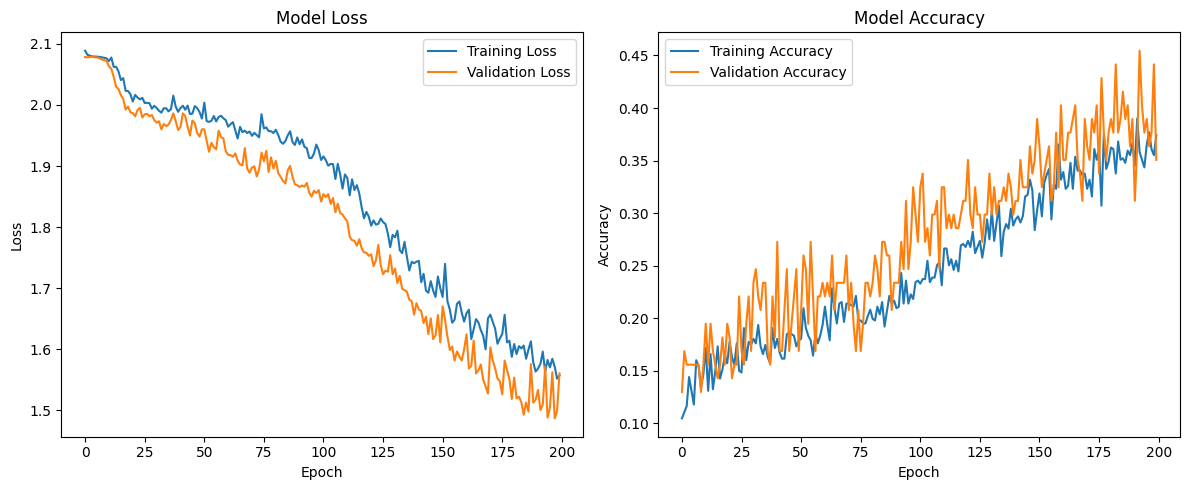

In [20]:
# Plot the training history
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Lets take a look at the test set performance
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3508 - loss: 1.5341 
Test Loss: 1.5341, Test Accuracy: 0.3508


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Classification Report:
              precision    recall  f1-score   support

     Control       0.50      0.75      0.60        24
   E_Hidrico       0.43      0.25      0.32        24
      Fus_EH       0.86      0.25      0.39        24
  Fus_EH_Ral       0.21      0.25      0.23        24
    Fusarium       0.26      0.25      0.26        24
      Ral_EH       0.19      0.38      0.25        24
     Ral_Fus       0.40      0.08      0.14        24
   Ralstonia       0.47      0.61      0.53        23

    accuracy                           0.35       191
   macro avg       0.41      0.35      0.34       191
weighted avg       0.41      0.35      0.34       191



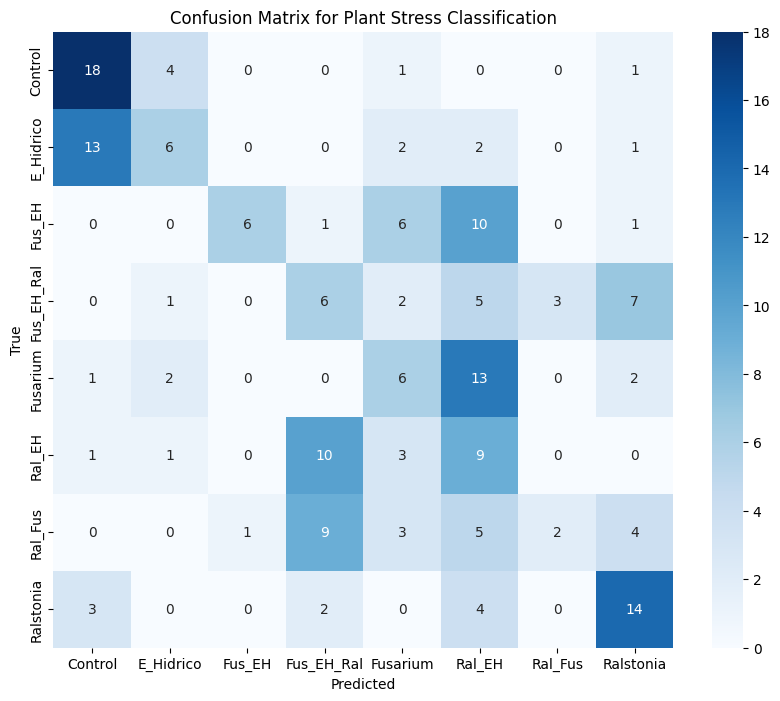

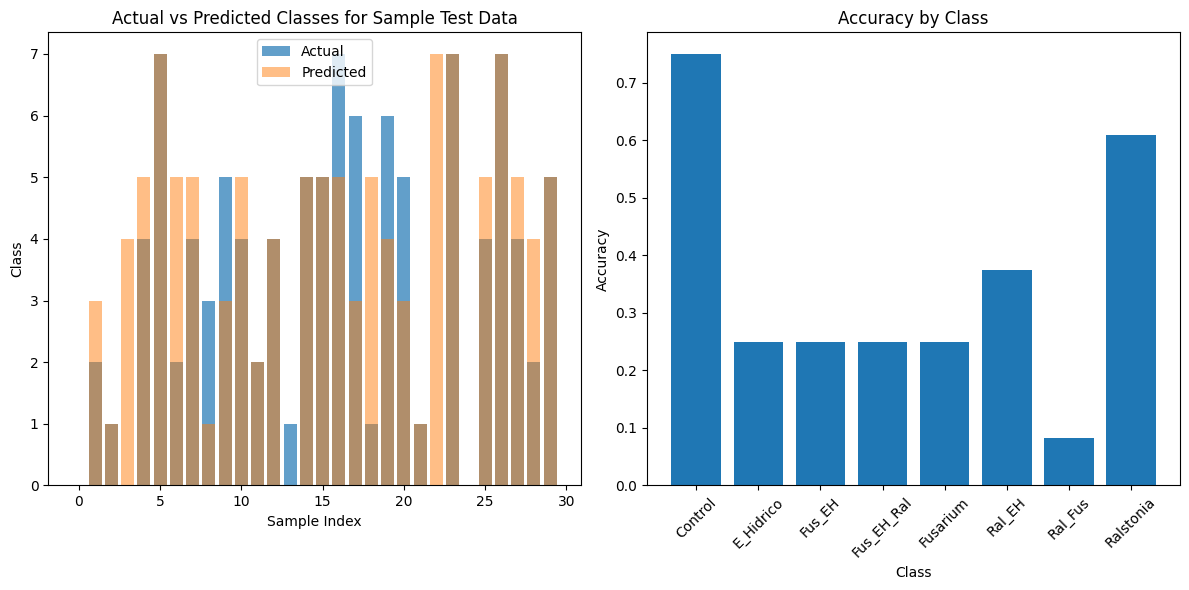

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate predictions for the test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create a confusion matrix

# Get the original class labels
class_names = encoder.categories_[0]

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Plant Stress Classification')

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Plot a sample of predictions vs actual values
plt.figure(figsize=(12, 6))
# Select a subset of test samples to display
sample_size = min(30, len(y_test))
indices = np.random.choice(range(len(y_test)), sample_size, replace=False)

# Plot comparison
plt.subplot(1, 2, 1)
plt.bar(range(sample_size), y_test[indices], alpha=0.7, label='Actual')
plt.bar(range(sample_size), y_pred_classes[indices], alpha=0.5, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()
plt.title('Actual vs Predicted Classes for Sample Test Data')

# Plot accuracy by class
plt.subplot(1, 2, 2)
class_accuracy = []
for i in range(len(class_names)):
    mask = y_test == i
    if np.sum(mask) > 0:  # Avoid division by zero
        accuracy = np.mean(y_pred_classes[mask] == i)
        class_accuracy.append(accuracy)
    else:
        class_accuracy.append(0)

plt.bar(class_names, class_accuracy)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy by Class')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### **Key Insights from Confusion Matrix:**

- **Success with Control and Ralstonia:** The highest numbers on the diagonal are for Control (18) and Ralstonia (14). This confirms the model is most confident and accurate with these two classes.

- **Major Confusion with "Control":** Look at the "E_Hidrico" (Water Stress) row. The model correctly identified only 6 samples, while it misclassified 13 of them as Control. This is a critical error, as the model thinks these stressed plants are healthy. This might happen if the spectral signs of early water stress are very subtle.

- **Inability to Distinguish Combined Stresses:** The model is very confused by the combined treatments. For example, in the Ral_EH row, it only correctly identified 3 samples. It confused the rest with Fus_EH_Ral (10 times) and Ral_Fus (9 times). This indicates that the spectral "fingerprints" of these different combined stresses are very similar, making it a very difficult task for the model.

- **Fusarium Confusion:** The model struggles with the "Fusarium" class, frequently mistaking it for "Ral_EH" (13 times) and "Fusarium" itself (6 times).